# Australian Rainfall Prediction Project
This notebook analyzes weather data from Australia to build a predictive model for rainfall occurrence.

## 1. Setup and Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import scipy.stats as stats
from sklearn import preprocessing

In [2]:
# Configure pandas to display all columns
pd.set_option("display.max_columns", None)

## 2. Data Loading and Initial Exploration

In [3]:
weather_data = pd.read_csv("weatherAUS.CSV")

In [4]:
print("First 5 rows of the dataset:")
display(weather_data.head())

First 5 rows of the dataset:


,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,WNW,20.0,24.0,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,WSW,4.0,22.0,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,WSW,19.0,26.0,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,E,11.0,9.0,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,NW,7.0,20.0,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


In [5]:
# Check dimensions of the dataset
print(f"Dataset dimensions: {weather_data.shape} (rows x columns)")

Dataset dimensions: (145460, 23) (rows x columns)


## 3. Feature Classification

In [6]:
# Identify numerical features
numerical_features = [feature for feature in weather_data.columns if weather_data[feature].dtypes != 'O']

In [7]:
# Split numerical features into discrete and continuous
discrete_features = [feature for feature in numerical_features if len(weather_data[feature].unique()) < 25]
continuous_features = [feature for feature in numerical_features if feature not in discrete_features]

In [8]:
# Identify categorical features
categorical_features = [feature for feature in weather_data.columns if feature not in numerical_features]

In [9]:
print(f"Numerical Features: {len(numerical_features)}")

Numerical Features: 16


In [10]:
print(f"- Discrete Features: {len(discrete_features)}")

- Discrete Features: 2


In [11]:
print(f"- Continuous Features: {len(continuous_features)}")

- Continuous Features: 14


In [12]:
print(f"Categorical Features: {len(categorical_features)}")

Categorical Features: 7


In [13]:
print("\nNumerical features list:")
print(numerical_features)


Numerical features list:
['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm']


In [14]:
print("\nDiscrete features list:")
print(discrete_features)


Discrete features list:
['Cloud9am', 'Cloud3pm']


In [15]:
print("\nContinuous features list:")
print(continuous_features)


Continuous features list:
['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Temp9am', 'Temp3pm']


In [ ]:
print("\nCategorical features list:")
print(categorical_features)

## 4. Missing Value Analysis

In [17]:
missing_values = weather_data.isnull().sum()
print("Missing values per column:")
print(missing_values[missing_values > 0].sort_values(ascending=False))

Missing values per column:
Sunshine         69835
Evaporation      62790
Cloud3pm         59358
Cloud9am         55888
Pressure9am      15065
Pressure3pm      15028
WindDir9am       10566
WindGustDir      10326
WindGustSpeed    10263
Humidity3pm       4507
WindDir3pm        4228
Temp3pm           3609
RainTomorrow      3267
Rainfall          3261
RainToday         3261
WindSpeed3pm      3062
Humidity9am       2654
Temp9am           1767
WindSpeed9am      1767
MinTemp           1485
MaxTemp           1261
dtype: int64


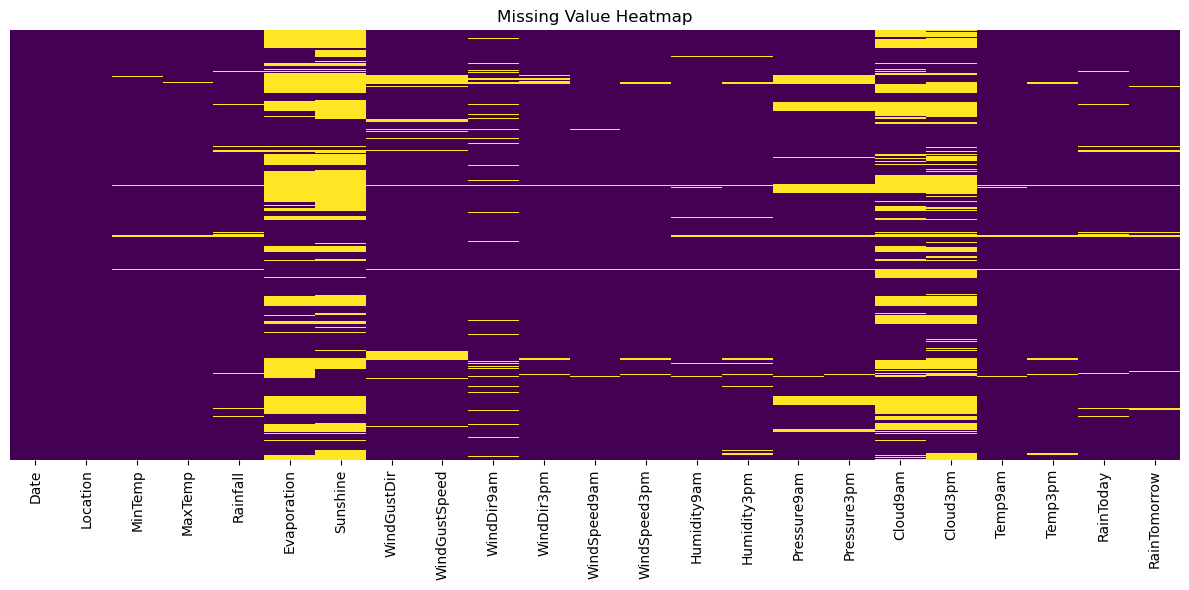

In [18]:
plt.figure(figsize=(12, 6))
sns.heatmap(weather_data.isnull(), yticklabels=False, cbar=False, cmap='viridis')
plt.title('Missing Value Heatmap')
plt.tight_layout()
plt.show()

### 4.1 Missing Value Imputation Strategies

In [19]:
# Function for random sample imputation
def random_sample_imputation(df, feature):
    """
    Impute missing values with random samples from the existing distribution
    """
    random_sample = df[feature].dropna().sample(df[feature].isnull().sum(), random_state=42)
    random_sample.index = df[df[feature].isnull()].index
    df.loc[df[feature].isnull(), feature] = random_sample
    return df

In [20]:
# Function for mode imputation
def mode_imputation(df, feature):
    """
    Impute missing values with the mode of the feature
    """
    mode_value = df[feature].value_counts().index[0]
    df[feature].fillna(mode_value, inplace=True)
    return df

In [21]:
# Apply random sample imputation for Evaporation and Sunshine
weather_data = random_sample_imputation(weather_data, "Evaporation")
weather_data = random_sample_imputation(weather_data, "Sunshine")

In [22]:
# For continuous features, fill missing values with median
for feature in continuous_features:
    if (weather_data[feature].isnull().sum() * 100 / len(weather_data)) > 0:
        weather_data[feature] = weather_data[feature].fillna(weather_data[feature].median())

In [23]:
# Apply mode imputation for Cloud9am and Cloud3pm
weather_data = mode_imputation(weather_data, "Cloud9am")
weather_data = mode_imputation(weather_data, "Cloud3pm")

In [24]:
# Check remaining missing values
remaining_missing = weather_data.isnull().sum()
print("\nRemaining missing values after imputation:")
print(remaining_missing[remaining_missing > 0].sort_values(ascending=False))


Remaining missing values after imputation:
WindDir9am      10566
WindGustDir     10326
WindDir3pm       4228
RainTomorrow     3267
RainToday        3261
dtype: int64


## 5. Feature Distribution Analysis

In [25]:
# Create distribution plots for continuous features
def plot_distributions(df, features, rows=3, cols=3):
    """
    Create distribution plots for a list of features
    """
    plt.figure(figsize=(15, 15))
    for i, feature in enumerate(features, 1):
        if i <= rows*cols:
            plt.subplot(rows, cols, i)
            sns.histplot(df[feature], kde=True)
            plt.title(f'Distribution of {feature}')
            plt.tight_layout()
    plt.show()

c:\Users\verma\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\verma\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\verma\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\verma\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

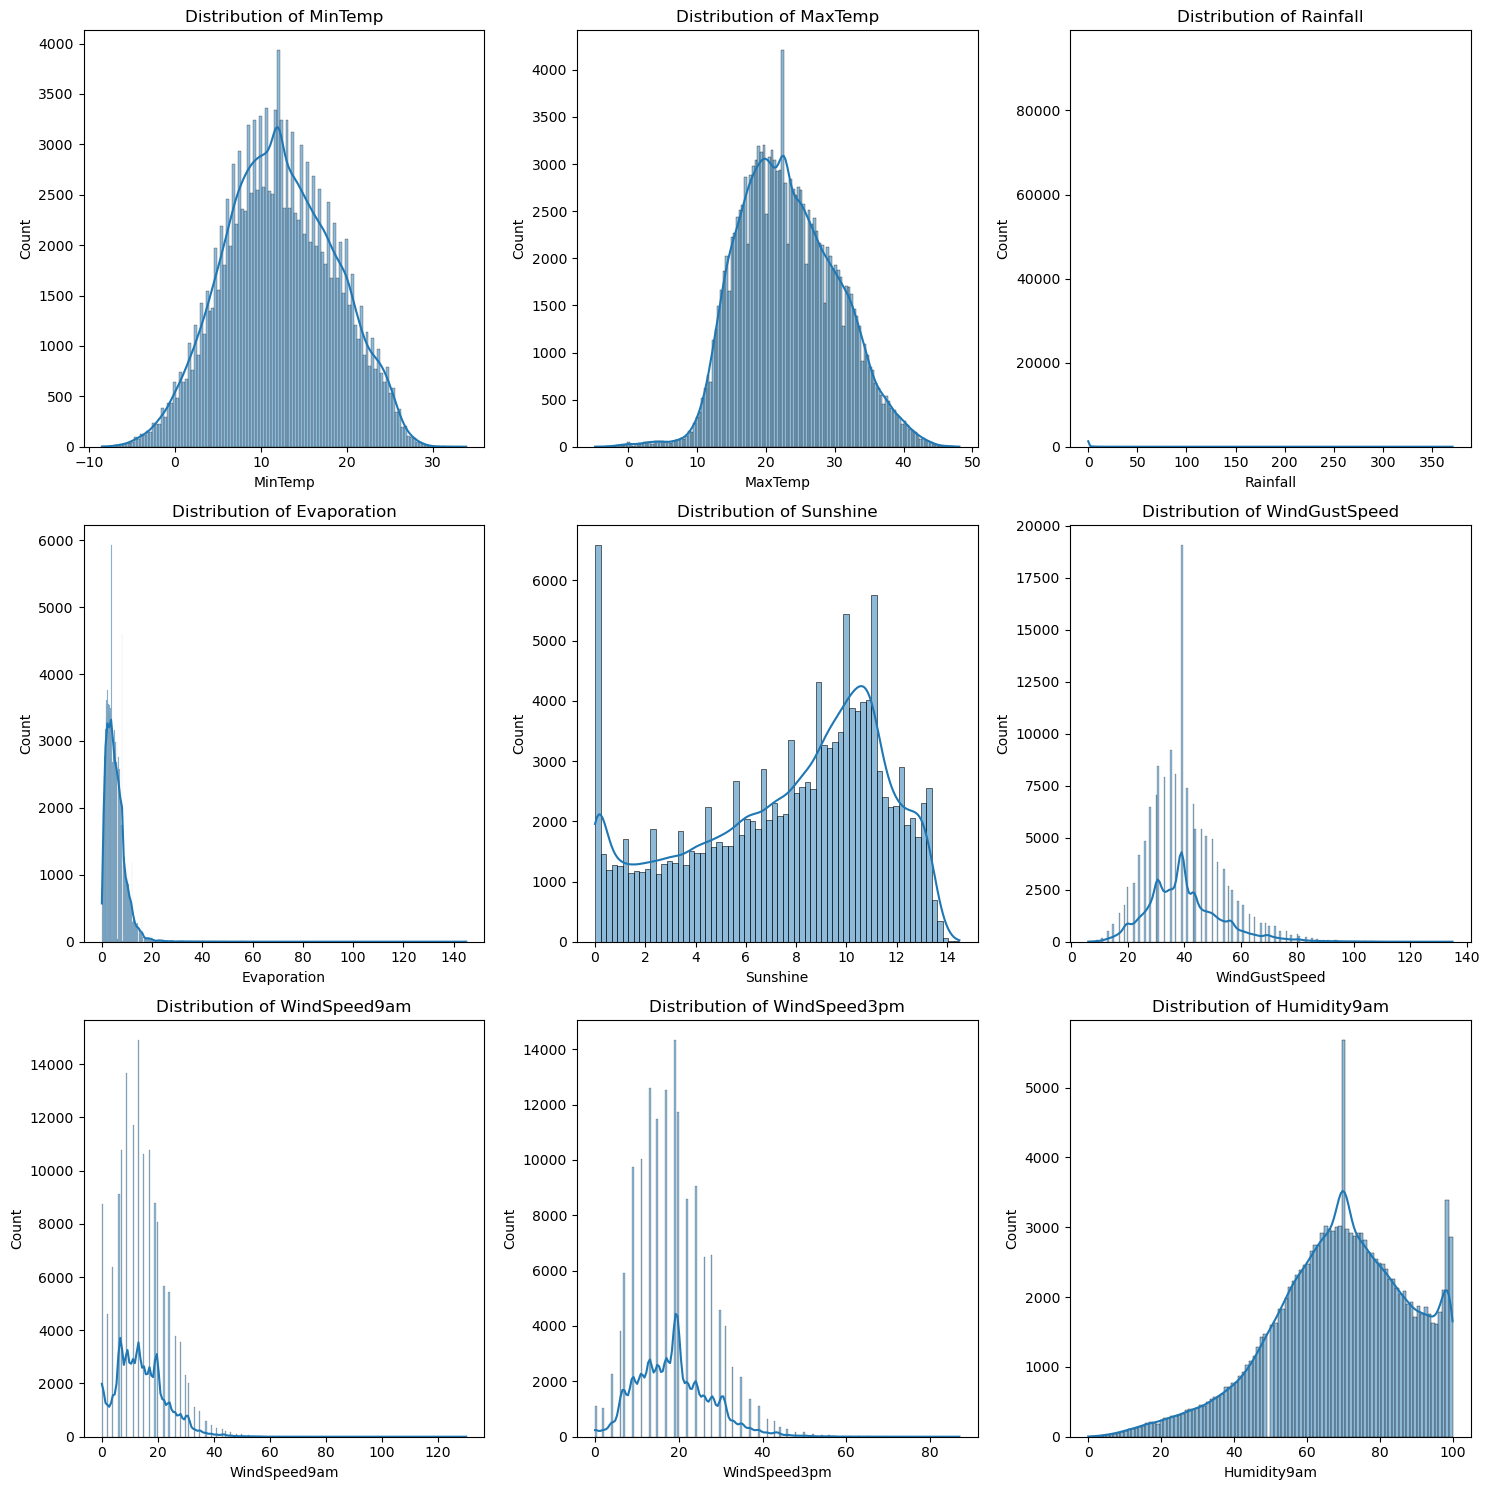

c:\Users\verma\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\verma\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\verma\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\verma\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

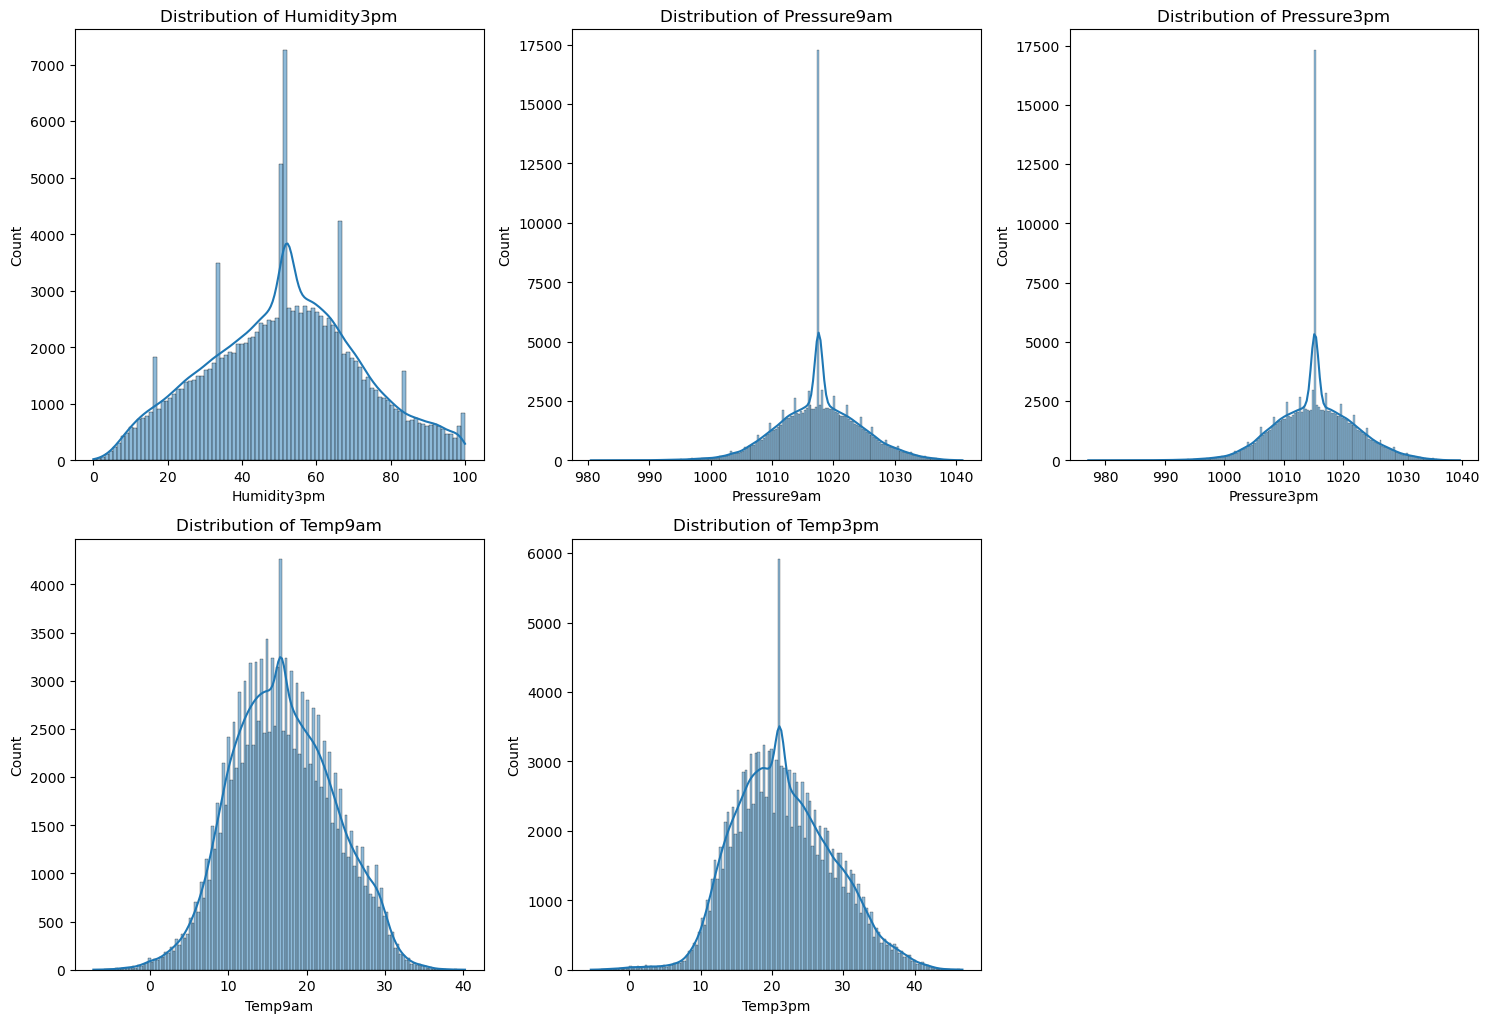

In [26]:
# Plot distributions in batches
batch_size = 9  # 3x3 grid
for i in range(0, len(continuous_features), batch_size):
    batch = continuous_features[i:i+batch_size]
    plot_distributions(weather_data, batch)

## 6. Target Variable Analysis

In [27]:
# Convert RainToday and RainTomorrow to binary
weather_data["RainToday"] = pd.get_dummies(weather_data["RainToday"], drop_first=True)
weather_data["RainTomorrow"] = pd.get_dummies(weather_data["RainTomorrow"], drop_first=True)

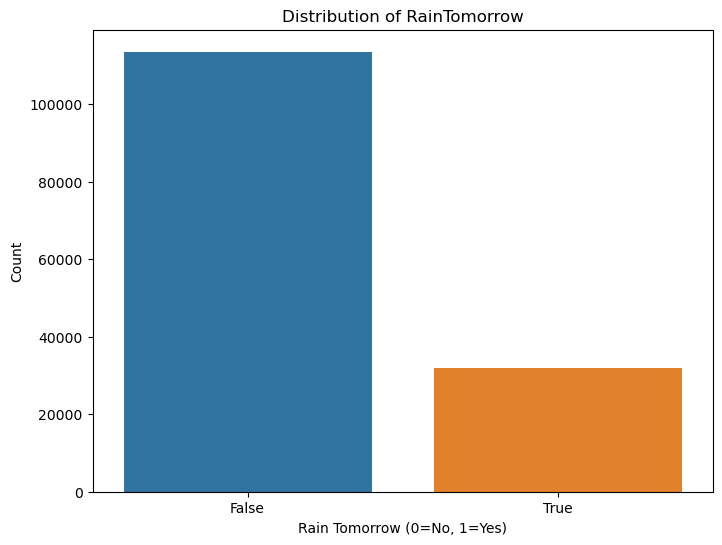

In [28]:
# Visualize the target variable distribution
plt.figure(figsize=(8, 6))
sns.countplot(x=weather_data["RainTomorrow"])
plt.title('Distribution of RainTomorrow')
plt.xlabel('Rain Tomorrow (0=No, 1=Yes)')
plt.ylabel('Count')
plt.show()

In [29]:
# Calculate class imbalance
rain_counts = weather_data["RainTomorrow"].value_counts()
print("Target variable distribution:")
print(f"No rain tomorrow: {rain_counts[0]} samples ({rain_counts[0]/len(weather_data)*100:.2f}%)")
print(f"Rain tomorrow: {rain_counts[1]} samples ({rain_counts[1]/len(weather_data)*100:.2f}%)")

Target variable distribution:
No rain tomorrow: 113583 samples (78.09%)
Rain tomorrow: 31877 samples (21.91%)


C:\Users\verma\AppData\Local\Temp\ipykernel_8076\2333903480.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"No rain tomorrow: {rain_counts[0]} samples ({rain_counts[0]/len(weather_data)*100:.2f}%)")
C:\Users\verma\AppData\Local\Temp\ipykernel_8076\2333903480.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"Rain tomorrow: {rain_counts[1]} samples ({rain_counts[1]/len(weather_data)*100:.2f}%)")


## 7. Categorical Feature Processing

In [30]:
# Analyze relationship between categorical features and target
print("Relationship between categorical features and RainTomorrow (mean values):")
for feature in categorical_features:
    if feature != 'Date':  # Skip Date as it's handled separately
        print(f"\n{feature}:")
        print(weather_data.groupby([feature])["RainTomorrow"].mean().sort_values(ascending=False))

Relationship between categorical features and RainTomorrow (mean values):

Location:
Location
Portland            0.363908
Walpole             0.315702
Cairns              0.312500
Dartmoor            0.306414
NorfolkIsland       0.305417
MountGambier        0.302632
Albany              0.296711
Witchcliffe         0.292124
CoffsHarbour        0.288800
MountGinini         0.269408
NorahHead           0.268975
Darwin              0.266834
Sydney              0.258672
SydneyAirport       0.257228
Ballarat            0.256908
GoldCoast           0.254934
Watsonia            0.245264
Newcastle           0.240540
Hobart              0.238334
Wollongong          0.234539
Williamtown         0.232635
Launceston          0.229934
Brisbane            0.222048
MelbourneAirport    0.217016
Adelaide            0.215471
Sale                0.213692
Albury              0.203289
Perth               0.202004
Melbourne           0.199186
Nuriootpa           0.196743
Penrith             0.195788
Badgery

In [31]:
# Create mapping dictionaries for wind direction features
wind_direction_mappings = {
    "WindGustDir": {'NNW':0, 'NW':1, 'WNW':2, 'N':3, 'W':4, 'WSW':5, 'NNE':6, 'S':7, 'SSW':8, 
                   'SW':9, 'SSE':10, 'NE':11, 'SE':12, 'ESE':13, 'ENE':14, 'E':15},
    
    "WindDir9am": {'NNW':0, 'N':1, 'NW':2, 'NNE':3, 'WNW':4, 'W':5, 'WSW':6, 'SW':7, 'SSW':8, 
                  'NE':9, 'S':10, 'SSE':11, 'ENE':12, 'SE':13, 'ESE':14, 'E':15},
    
    "WindDir3pm": {'NW':0, 'NNW':1, 'N':2, 'WNW':3, 'W':4, 'NNE':5, 'WSW':6, 'SSW':7, 'S':8, 
                  'SW':9, 'SE':10, 'NE':11, 'SSE':12, 'ENE':13, 'E':14, 'ESE':15}
}

In [32]:
# Apply wind direction mappings
for feature, mapping in wind_direction_mappings.items():
    weather_data[feature] = weather_data[feature].map(mapping)
    # Fill missing values with most common direction
    weather_data[feature] = weather_data[feature].fillna(weather_data[feature].value_counts().index[0])

In [33]:
# Location mapping based on rainfall probability
# First, analyze rainfall probability by location
location_rain_probs = weather_data.groupby(["Location"])["RainTomorrow"].mean().sort_values(ascending=False)
print("\nLocations ranked by rainfall probability:")
print(location_rain_probs)


Locations ranked by rainfall probability:
Location
Portland            0.363908
Walpole             0.315702
Cairns              0.312500
Dartmoor            0.306414
NorfolkIsland       0.305417
MountGambier        0.302632
Albany              0.296711
Witchcliffe         0.292124
CoffsHarbour        0.288800
MountGinini         0.269408
NorahHead           0.268975
Darwin              0.266834
Sydney              0.258672
SydneyAirport       0.257228
Ballarat            0.256908
GoldCoast           0.254934
Watsonia            0.245264
Newcastle           0.240540
Hobart              0.238334
Wollongong          0.234539
Williamtown         0.232635
Launceston          0.229934
Brisbane            0.222048
MelbourneAirport    0.217016
Adelaide            0.215471
Sale                0.213692
Albury              0.203289
Perth               0.202004
Melbourne           0.199186
Nuriootpa           0.196743
Penrith             0.195788
BadgerysCreek       0.193752
PerthAirport        

In [34]:
# Create location mapping dictionary
location_mapping = {location: i+1 for i, location in enumerate(location_rain_probs.index)}
weather_data["Location"] = weather_data["Location"].map(location_mapping)

## 8. Date Feature Engineering

In [35]:
# Convert Date to datetime format
weather_data["Date"] = pd.to_datetime(weather_data["Date"], format="%Y-%m-%d", errors="coerce")

In [36]:
# Extract month and day features
weather_data["Month"] = weather_data["Date"].dt.month
weather_data["Day"] = weather_data["Date"].dt.day

## 9. Outlier Detection and Treatment
We'll use the IQR method to detect and handle outliers in continuous features.

In [37]:
def detect_and_handle_outliers(df, feature):
    """
    Detect outliers using IQR method and cap them at upper/lower bounds
    """
    Q1 = df[feature].quantile(0.25)
    Q3 = df[feature].quantile(0.75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - (1.5 * IQR)
    upper_bound = Q3 + (1.5 * IQR)
    
    print(f"{feature}: Lower bound = {lower_bound:.2f}, Upper bound = {upper_bound:.2f}")
    
    # Cap outliers
    df.loc[df[feature] > upper_bound, feature] = upper_bound
    df.loc[df[feature] < lower_bound, feature] = lower_bound
    
    return df

In [38]:
# Create box plots before outlier treatment
def plot_boxplots(df, features, rows=3, cols=3, title_prefix=""):
    """
    Create box plots for a list of features
    """
    plt.figure(figsize=(15, 15))
    for i, feature in enumerate(features, 1):
        if i <= rows*cols:
            plt.subplot(rows, cols, i)
            sns.boxplot(x=df[feature])
            plt.title(f'{title_prefix} {feature}')
            plt.tight_layout()
    plt.show()

Boxplots before outlier treatment:


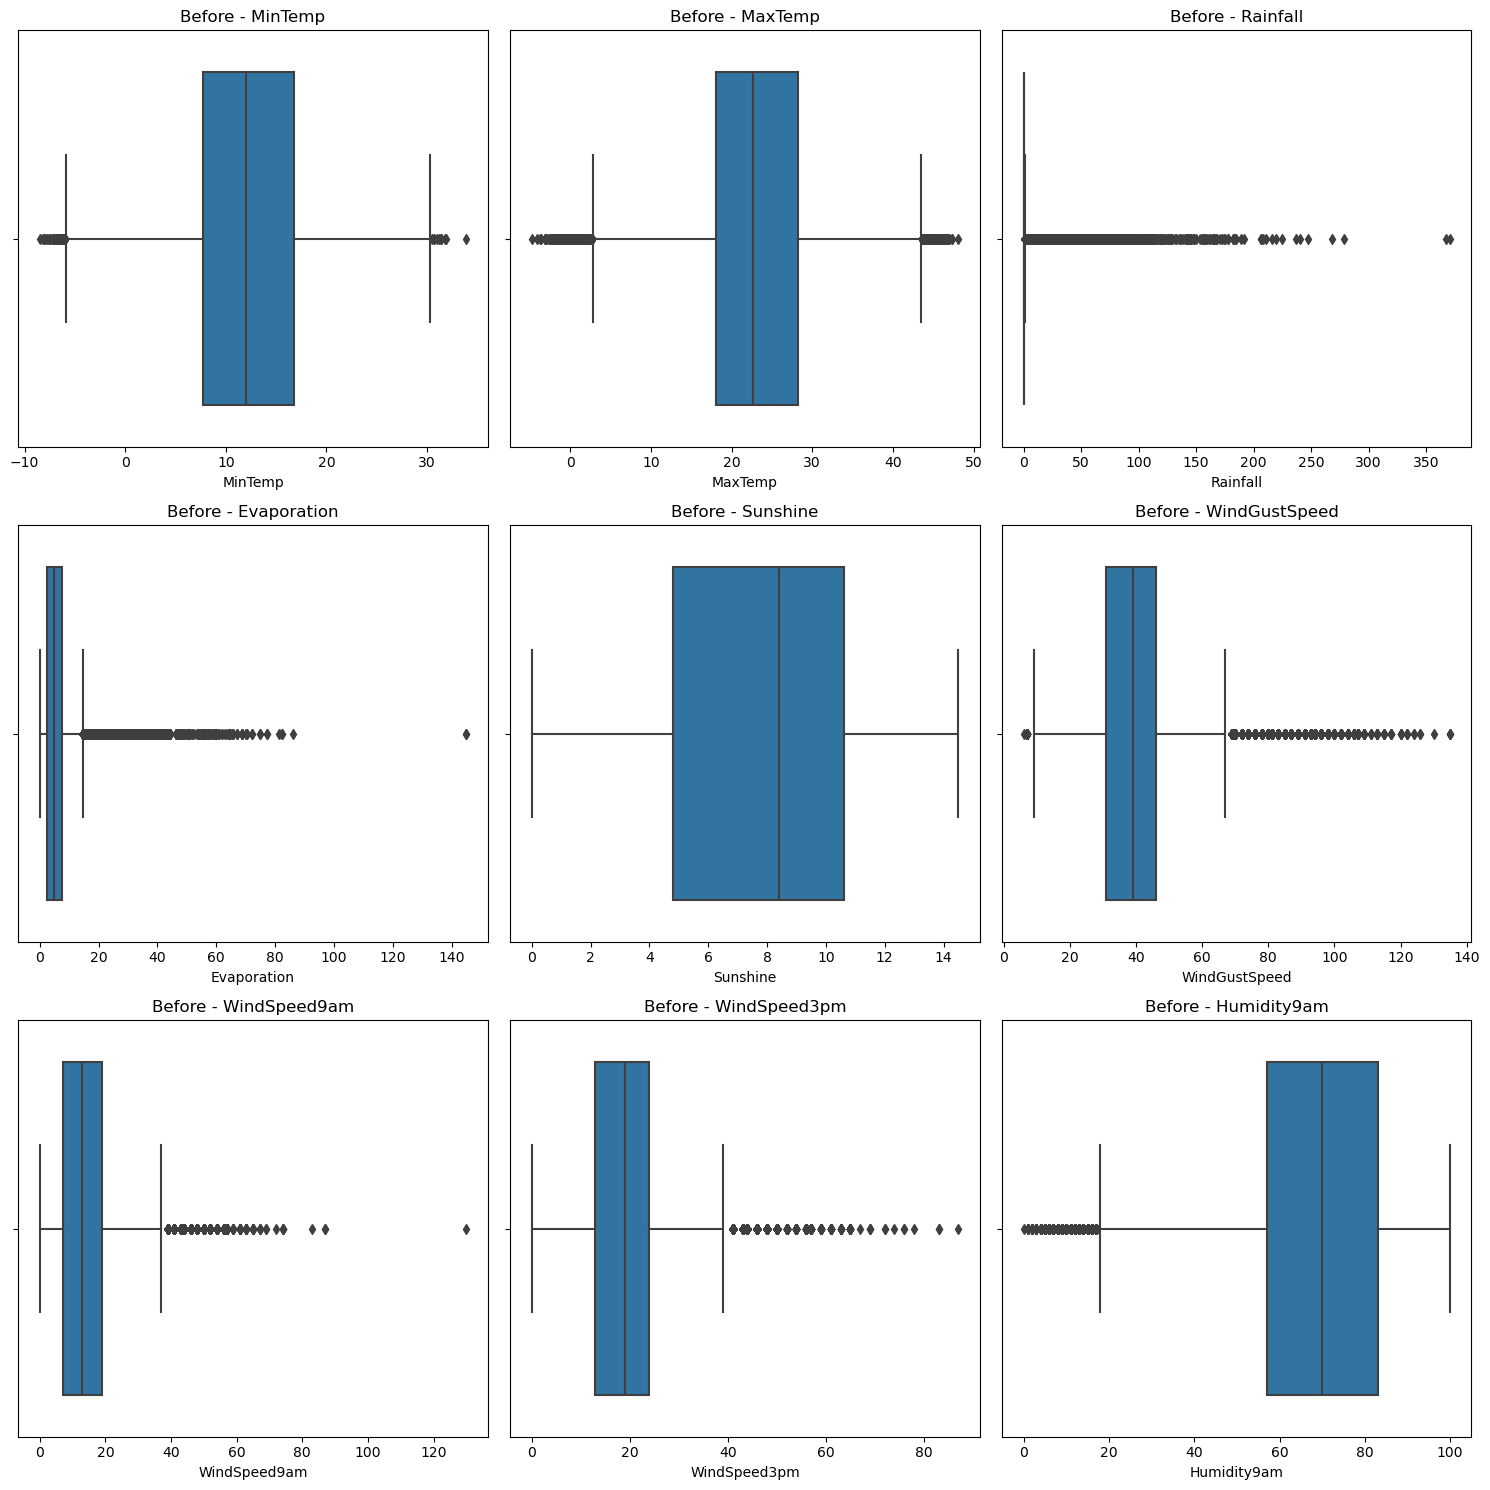

In [39]:
# Plot boxplots before outlier treatment
print("Boxplots before outlier treatment:")
plot_boxplots(weather_data, continuous_features, title_prefix="Before -")

In [40]:
# Handle outliers for all continuous features
print("\nOutlier bounds:")
for feature in continuous_features:
    weather_data = detect_and_handle_outliers(weather_data, feature)


Outlier bounds:
MinTemp: Lower bound = -5.95, Upper bound = 30.45
MaxTemp: Lower bound = 2.70, Upper bound = 43.50
Rainfall: Lower bound = -0.90, Upper bound = 1.50
Evaporation: Lower bound = -4.60, Upper bound = 14.60
Sunshine: Lower bound = -3.90, Upper bound = 19.30
WindGustSpeed: Lower bound = 8.50, Upper bound = 68.50
WindSpeed9am: Lower bound = -11.00, Upper bound = 37.00
WindSpeed3pm: Lower bound = -3.50, Upper bound = 40.50
Humidity9am: Lower bound = 18.00, Upper bound = 122.00
Humidity3pm: Lower bound = -5.00, Upper bound = 107.00
Pressure9am: Lower bound = 1001.05, Upper bound = 1034.25
Pressure3pm: Lower bound = 998.65, Upper bound = 1031.85
Temp9am: Lower bound = -1.50, Upper bound = 35.30
Temp3pm: Lower bound = 2.45, Upper bound = 40.45



Boxplots after outlier treatment:


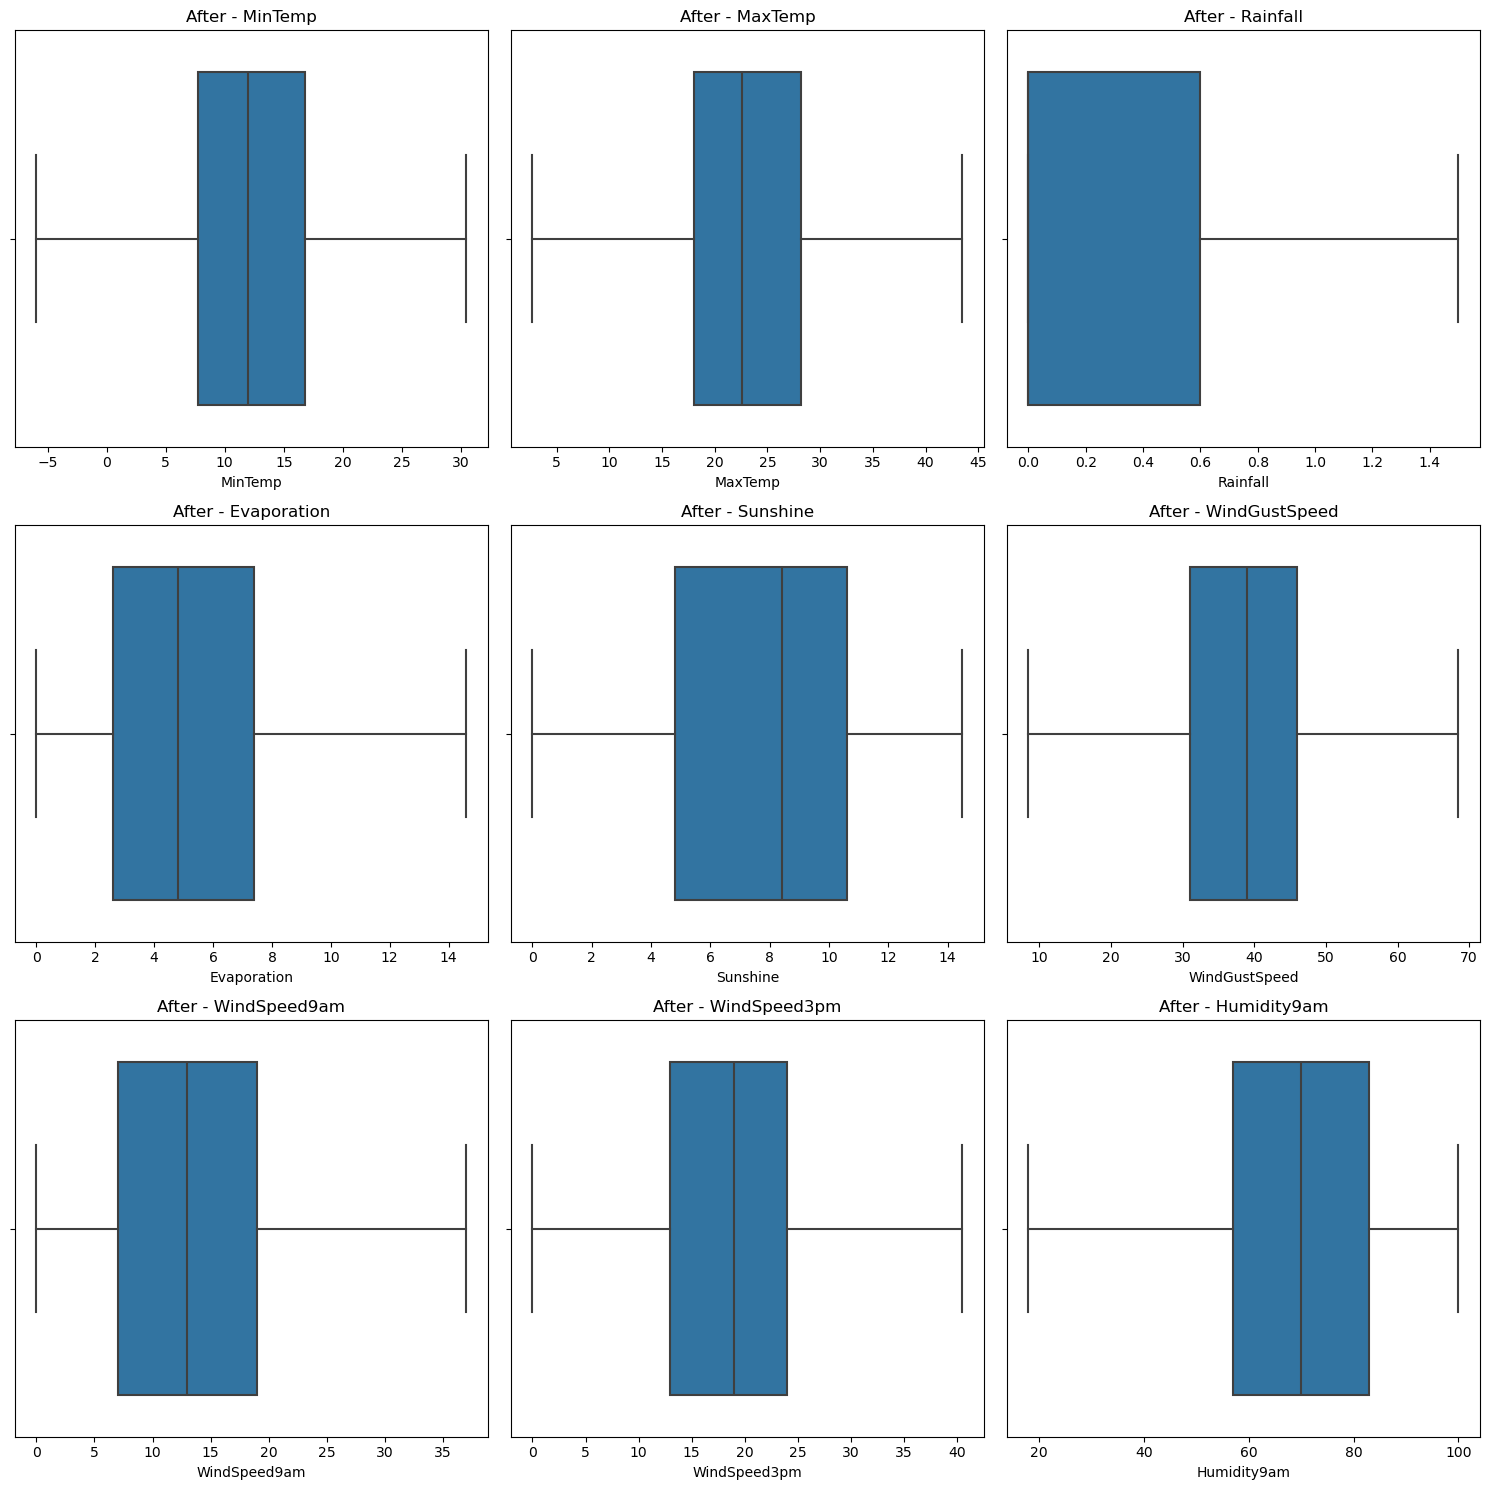

In [41]:
# Plot boxplots after outlier treatment
print("\nBoxplots after outlier treatment:")
plot_boxplots(weather_data, continuous_features, title_prefix="After -")

## 10. Normality Check

In [42]:
# Create QQ plots to check normality
def create_qq_plots(df, features, rows=2, cols=2):
    """
    Create QQ plots for assessing normality of features
    """
    for i in range(0, len(features), rows*cols):
        plt.figure(figsize=(15, 12))
        for j, feature in enumerate(features[i:i+rows*cols], 1):
            plt.subplot(rows, cols, j)
            
            # Histogram
            plt.subplot(rows, 2*cols, 2*j-1)
            df[feature].hist(bins=30)
            plt.title(f'Histogram of {feature}')
            
            # QQ plot
            plt.subplot(rows, 2*cols, 2*j)
            stats.probplot(df[feature].dropna(), dist="norm", plot=plt)
            plt.title(f'QQ Plot of {feature}')
            
        plt.tight_layout()
        plt.show()

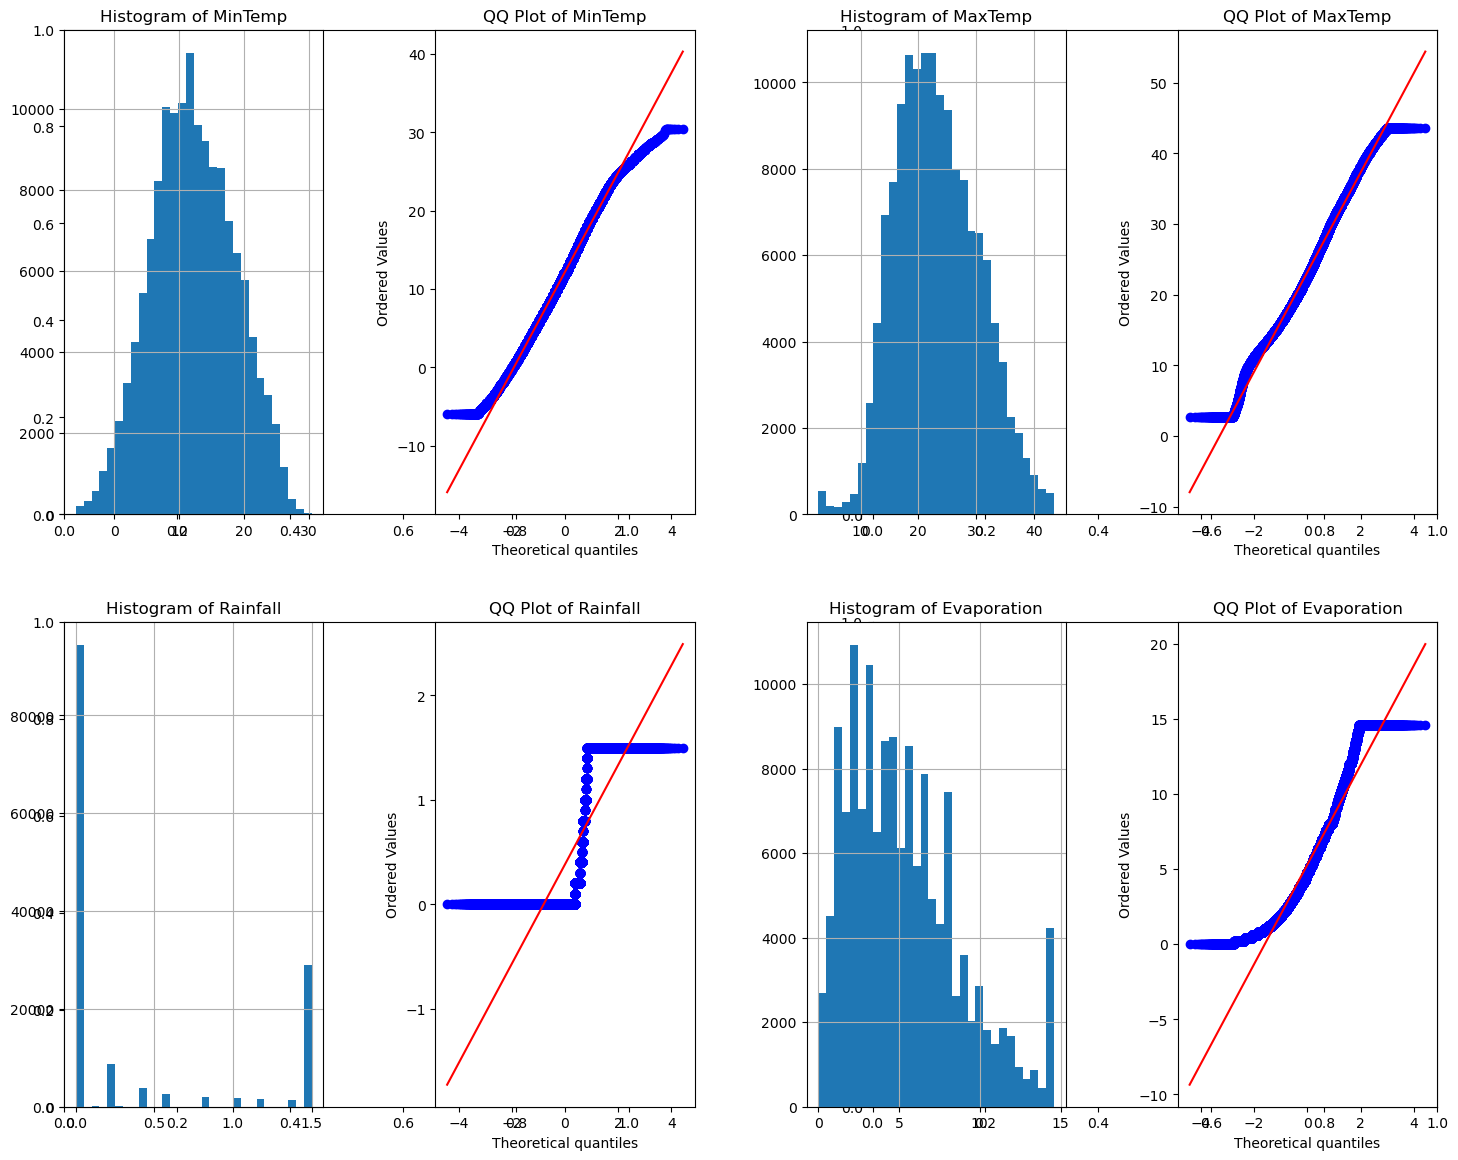

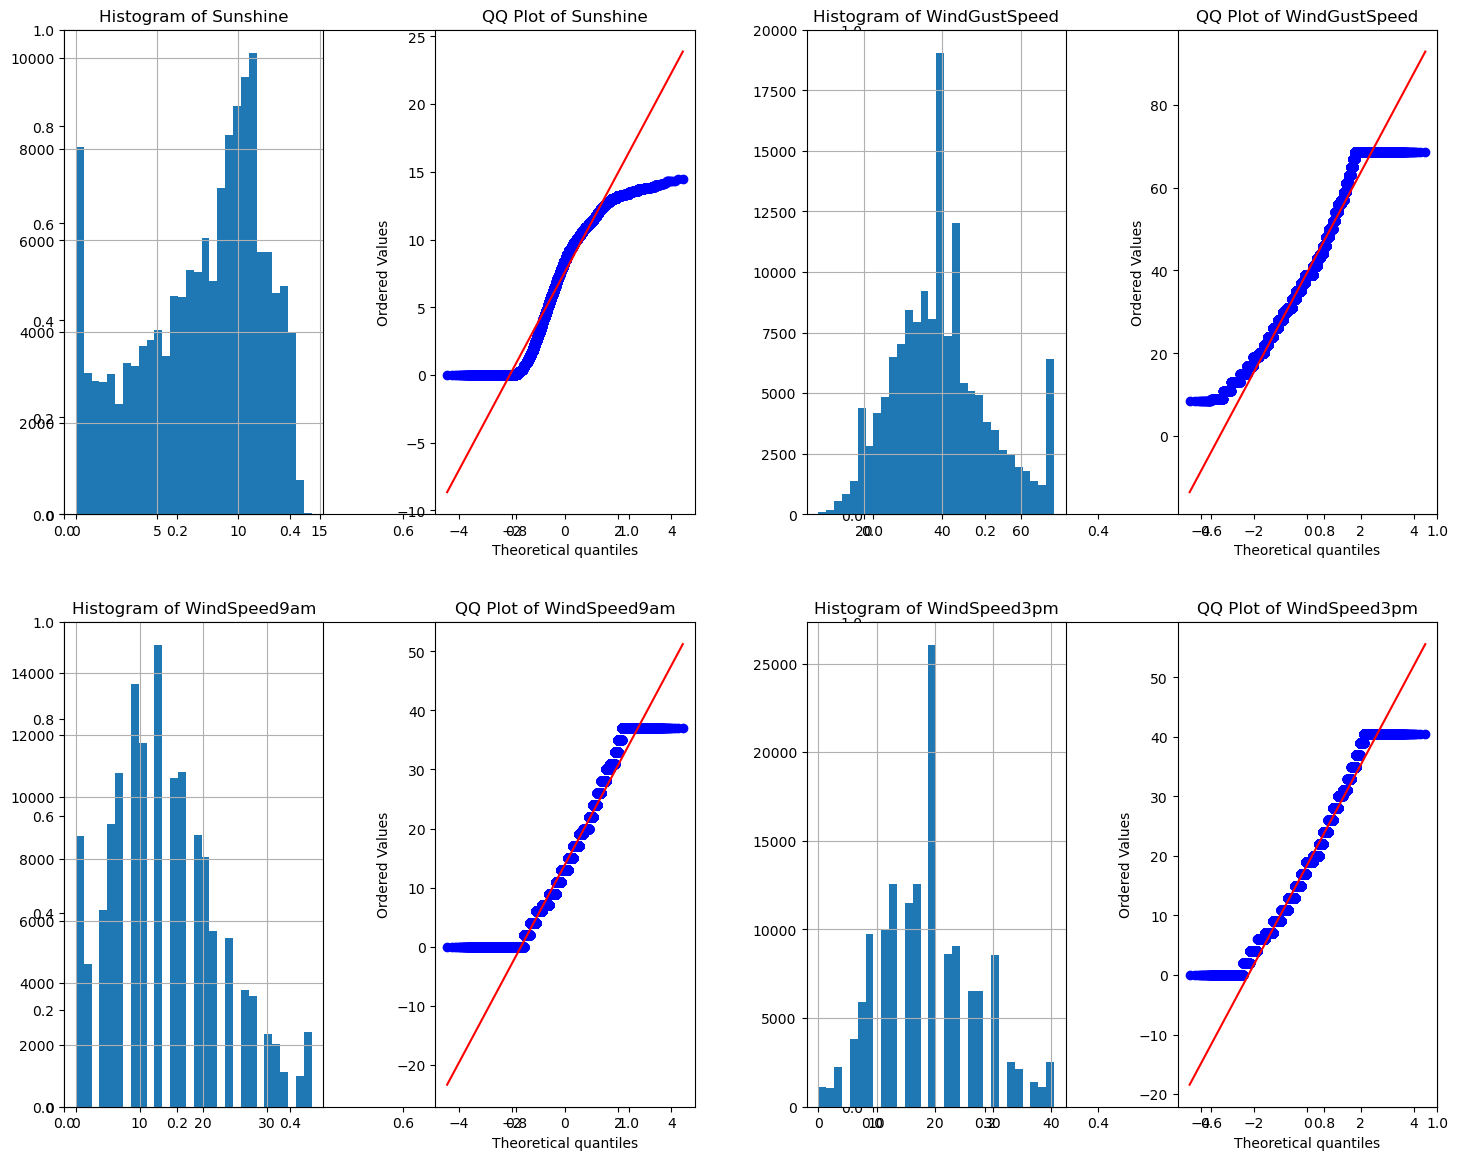

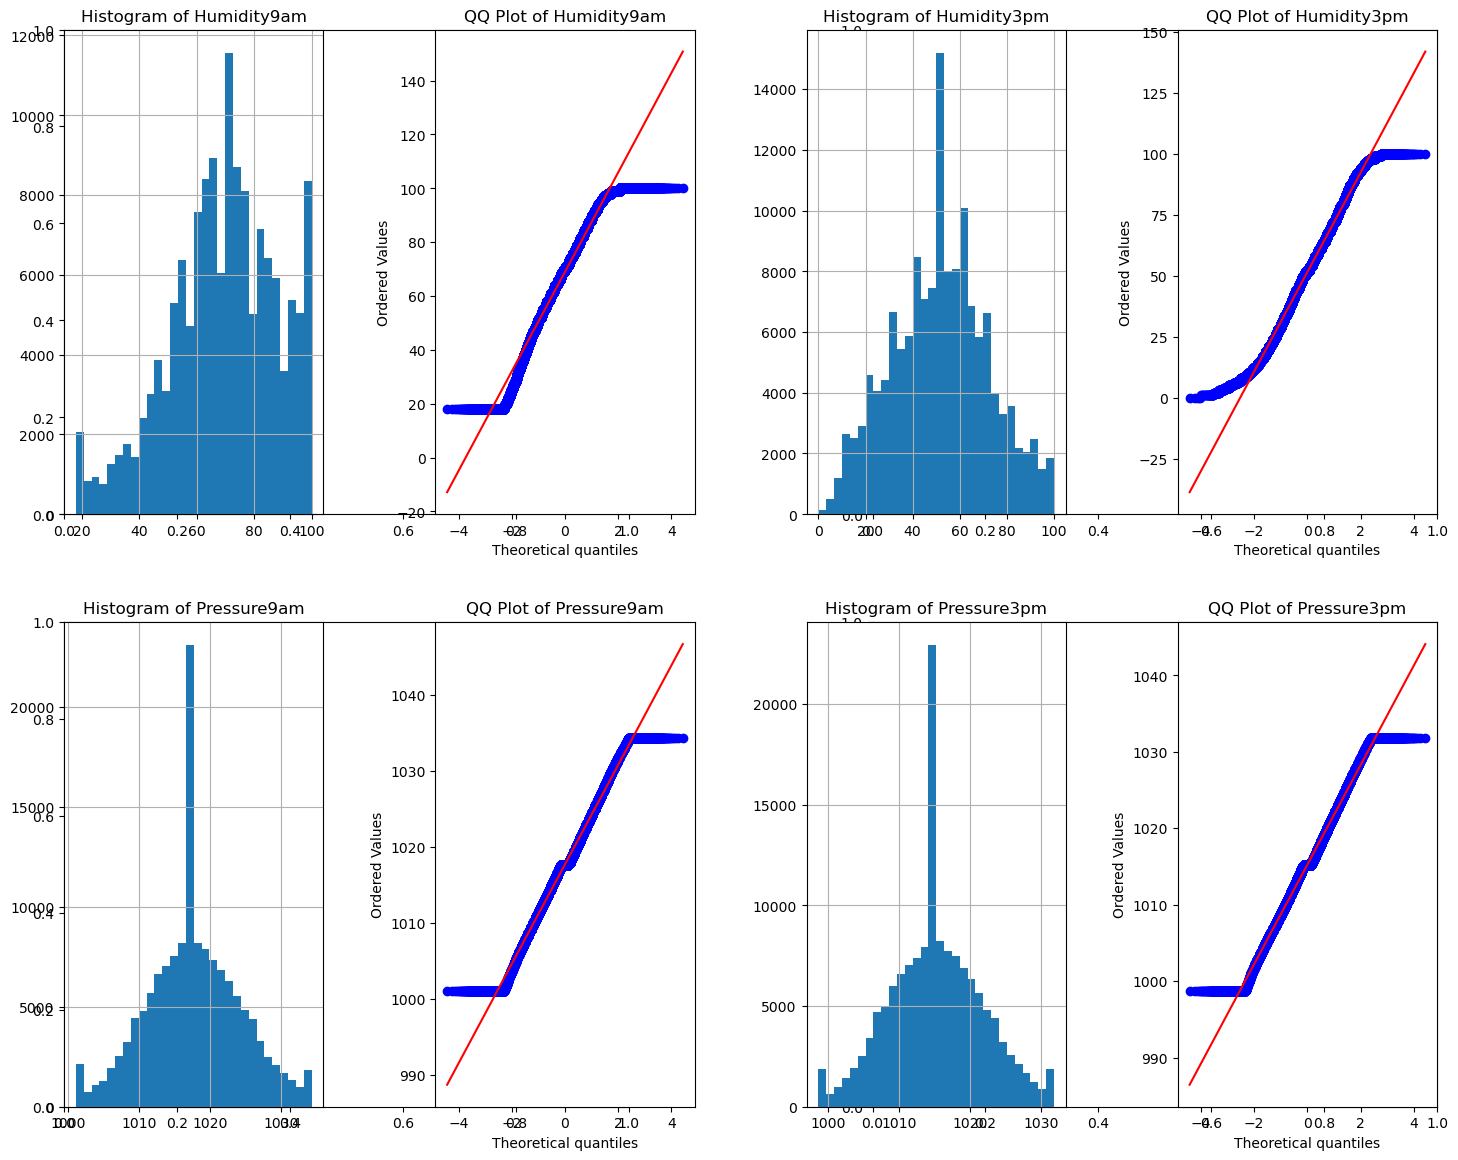

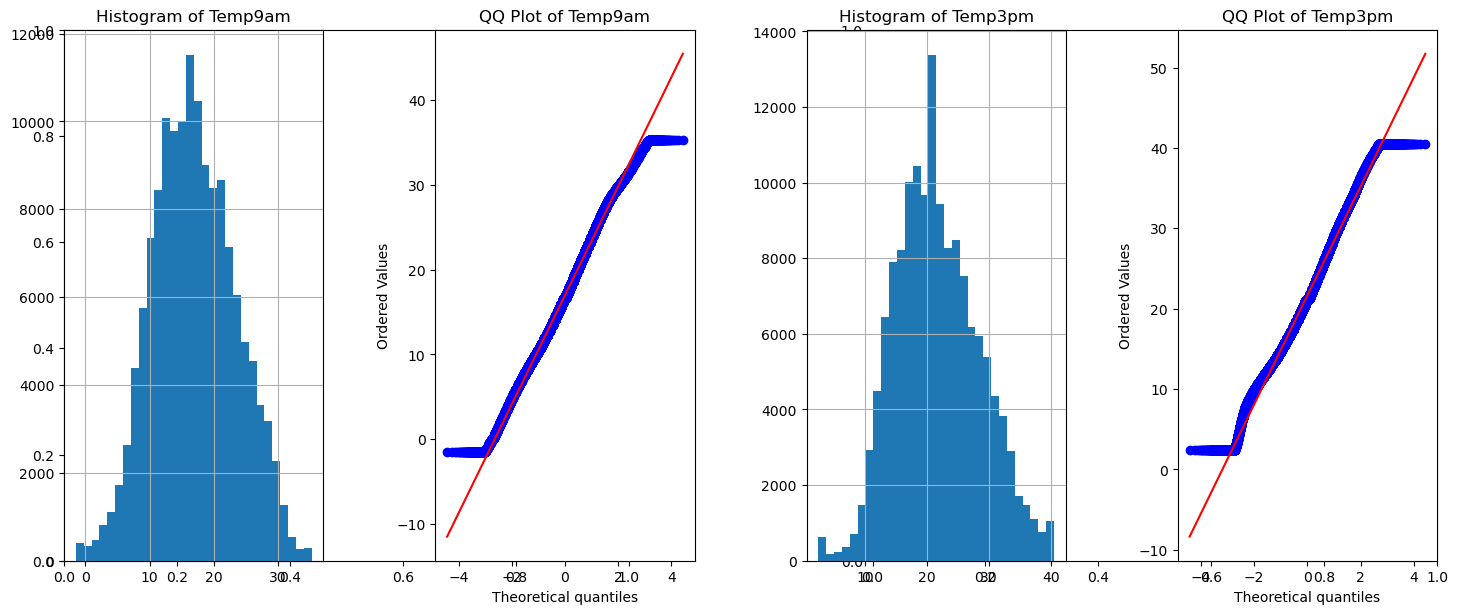

In [43]:
# Create QQ plots in batches
batch_size = 4  # 2x2 grid
for i in range(0, len(continuous_features), batch_size):
    batch = continuous_features[i:i+batch_size]
    create_qq_plots(weather_data, batch)

## 11. Feature Correlation Analysis

In [44]:
# Calculate correlation matrix for numerical features
correlation_matrix = weather_data[numerical_features].corr()

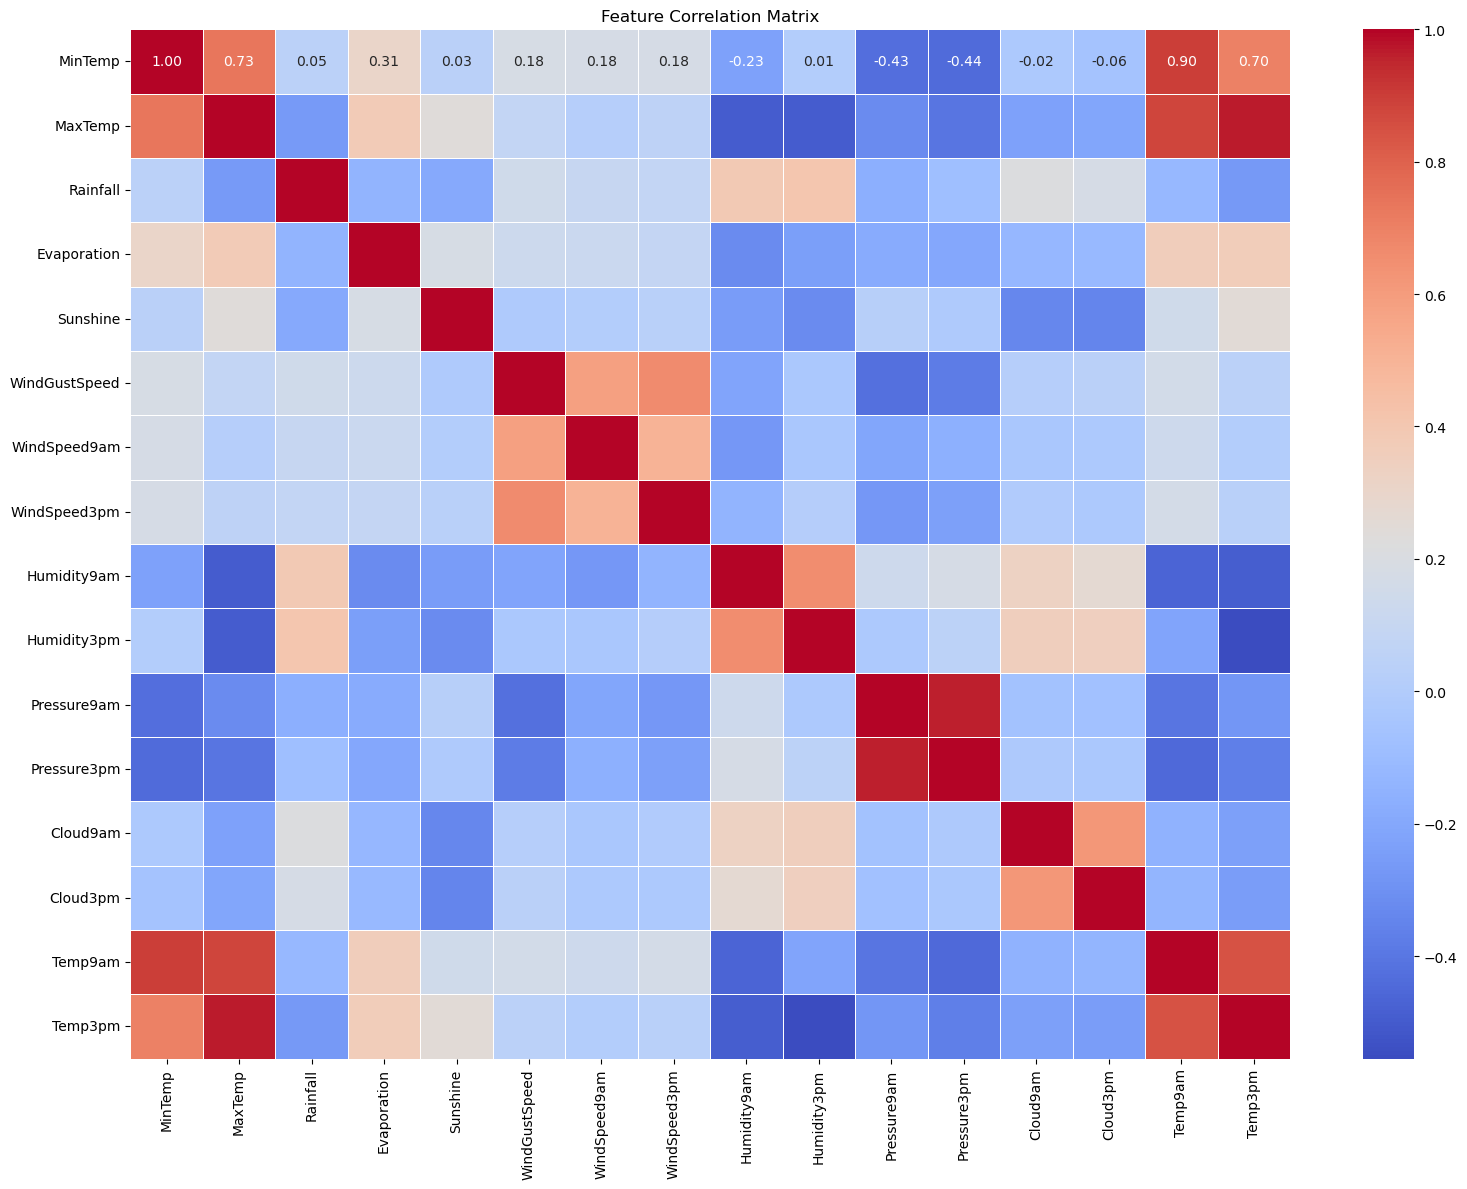

In [45]:
# Plot heatmap
plt.figure(figsize=(16, 12))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.show()

In [50]:
features_with_target = numerical_features.copy()
if 'RainTomorrow' not in features_with_target:
    features_with_target.append('RainTomorrow')
correlation_matrix = weather_data[features_with_target].corr()
target_correlations = correlation_matrix['RainTomorrow'].sort_values(ascending=False)
print("Feature correlations with RainTomorrow:")
print(target_correlations)

Feature correlations with RainTomorrow:
RainTomorrow     1.000000
Humidity3pm      0.433167
Rainfall         0.323354
Humidity9am      0.252190
Cloud3pm         0.233071
WindGustSpeed    0.216164
Cloud9am         0.202919
WindSpeed9am     0.084947
MinTemp          0.082255
WindSpeed3pm     0.081106
Temp9am         -0.025379
Evaporation     -0.074759
MaxTemp         -0.156313
Temp3pm         -0.187675
Pressure3pm     -0.209378
Pressure9am     -0.228542
Sunshine        -0.232503
Name: RainTomorrow, dtype: float64


## 12. Save Preprocessed Dataset

In [51]:
# Drop the original Date column as we've extracted the needed components
weather_data = weather_data.drop('Date', axis=1)

In [52]:
weather_data.to_csv("weather_preprocessed.csv", index=False)
print("Preprocessed data saved to 'weather_preprocessed.csv'")

Preprocessed data saved to 'weather_preprocessed.csv'


In [53]:
# Display the final preprocessed dataset
print("\nFinal preprocessed dataset:")
display(weather_data.head())
print(f"Final dataset shape: {weather_data.shape}")


Final preprocessed dataset:


,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,Month,Day
0,27,13.4,22.9,0.6,6.4,0.4,4.0,44.0,5.0,3.0,20.0,24.0,71.0,22.0,1007.7,1007.1,8.0,7.0,16.9,21.8,False,False,12,1
1,27,7.4,25.1,0.0,7.6,11.2,2.0,44.0,0.0,6.0,4.0,22.0,44.0,25.0,1010.6,1007.8,7.0,7.0,17.2,24.3,False,False,12,2
2,27,12.9,25.7,0.0,8.0,0.7,5.0,46.0,5.0,6.0,19.0,26.0,38.0,30.0,1007.6,1008.7,7.0,2.0,21.0,23.2,False,False,12,3
3,27,9.2,28.0,0.0,2.6,7.3,11.0,24.0,13.0,14.0,11.0,9.0,45.0,16.0,1017.6,1012.8,7.0,7.0,18.1,26.5,False,False,12,4
4,27,17.5,32.3,1.0,2.8,0.1,4.0,41.0,12.0,0.0,7.0,20.0,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,False,False,12,5


Final dataset shape: (145460, 24)
